# 套件 import

In [44]:
import numpy as np
import pandas as pd
import nltk
from tqdm import tqdm
import pickle, json #, pyodbc
import datetime as dt
import torch, traceback
# from keras.preprocessing.sequence import pad_sequences  # 報錯
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
import string
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, BertModel

In [34]:
print(torch.__version__)
print(transformers.__version__)

1.13.1
4.24.0


In [45]:
#True
torch.cuda.is_available()

False

In [46]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 讀取檔案

embedding_df：將mixFitData的品項加上相對應的 訓練資料標籤(新+舊).csv中的feature，只取全部都有值的品項<br>
共有3769個品項(包含上下身)

In [47]:
embedding_df = pd.read_pickle("embedding_df.pickle")
embedding_df

,款號搭配,季別,Dimension,標籤類型,元素,風格,Material,花型
0,AB0116,夏,上衣,T-SHIRT,長版短袖,柔美氣質優雅微甜女孩,棉一般含棉量60蕾絲,素面色
1,AB0194,夏,,,,,,
2,AB0391,夏,,,,,,
3,AB0435,夏,上衣,T-SHIRT,正常短袖,,棉一般含棉量60聚酯纖維,字母素面色
4,AB0848,夏,上衣,T-SHIRT,正常短袖,無印風簡約風,竹節棉,素面色
...,...,...,...,...,...,...,...,...
7068,QA1183,冬,裙子,A字裙,短裙,可愛女孩系微甜女孩,純棉全棉高棉含棉量95以上聚酯纖維網紗,拼色配色
7069,QA1185,四季,褲子,哈倫褲燈籠褲,長褲全長,無印風簡約風休閒風,聚酯纖維,素面色
7070,QA1186,四季,褲子,連身褲吊帶褲,長褲全長,街頭風可愛休閒風,純棉全棉高棉含棉量95以上,卡通
7071,QA1189,冬,裙子,A字裙,短裙,簡約風學院風休閒風,毛呢,格紋


## 資料前處理

In [48]:
bert_input_df = embedding_df[["款號搭配"]]
bert_input_df = bert_input_df.rename({'款號搭配':'款號'}, axis='columns')
bert_input_df = bert_input_df.reset_index(drop=True)
bert_input_df.to_csv('all_mainID.csv', index=False, encoding='utf_8_sig')
bert_input_df

,款號
0,AB0116
1,AB0194
2,AB0391
3,AB0435
4,AB0848
...,...
7068,QA1183
7069,QA1185
7070,QA1186
7071,QA1189


In [39]:
list(embedding_df.iloc[1])[1:] # 去掉款項(只留特徵值)


['夏', '', '', '', '', '', '']

In [49]:
Label = []
for i in tqdm(range(len(embedding_df))):
    label_list = list(embedding_df.iloc[i])[1:]
    while '' in label_list: #去除list裡面的空字串
        label_list.remove('')
    Label.append(label_list) # 去掉款項(只留特徵值)

100%|██████████| 7073/7073 [00:00<00:00, 13792.18it/s]


In [50]:
bert_input_df['Label'] = Label # 將特徵值新增進dataframe(bert_input_df)中

In [51]:
bert_input_df

,款號,Label
0,AB0116,"[夏, 上衣, T-SHIRT, 長版短袖, 柔美氣質優雅微甜女孩, 棉一般含棉量60蕾絲,..."
1,AB0194,[夏]
2,AB0391,[夏]
3,AB0435,"[夏, 上衣, T-SHIRT, 正常短袖, 棉一般含棉量60聚酯纖維, 字母素面色]"
4,AB0848,"[夏, 上衣, T-SHIRT, 正常短袖, 無印風簡約風, 竹節棉, 素面色]"
...,...,...
7068,QA1183,"[冬, 裙子, A字裙, 短裙, 可愛女孩系微甜女孩, 純棉全棉高棉含棉量95以上聚酯纖維網..."
7069,QA1185,"[四季, 褲子, 哈倫褲燈籠褲, 長褲全長, 無印風簡約風休閒風, 聚酯纖維, 素面色]"
7070,QA1186,"[四季, 褲子, 連身褲吊帶褲, 長褲全長, 街頭風可愛休閒風, 純棉全棉高棉含棉量95以上..."
7071,QA1189,"[冬, 裙子, A字裙, 短裙, 簡約風學院風休閒風, 毛呢, 格紋]"


In [52]:
bert_input_df['Label'] = bert_input_df['Label'].apply(lambda x: ''.join(x))
bert_input_df

,款號,Label
0,AB0116,夏上衣T-SHIRT長版短袖柔美氣質優雅微甜女孩棉一般含棉量60蕾絲素面色
1,AB0194,夏
2,AB0391,夏
3,AB0435,夏上衣T-SHIRT正常短袖棉一般含棉量60聚酯纖維字母素面色
4,AB0848,夏上衣T-SHIRT正常短袖無印風簡約風竹節棉素面色
...,...,...
7068,QA1183,冬裙子A字裙短裙可愛女孩系微甜女孩純棉全棉高棉含棉量95以上聚酯纖維網紗拼色配色
7069,QA1185,四季褲子哈倫褲燈籠褲長褲全長無印風簡約風休閒風聚酯纖維素面色
7070,QA1186,四季褲子連身褲吊帶褲長褲全長街頭風可愛休閒風純棉全棉高棉含棉量95以上卡通
7071,QA1189,冬裙子A字裙短裙簡約風學院風休閒風毛呢格紋


# BERT embedding

In [13]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, BertModel
# model_path = 'ckiplab/bert-base-chinese'
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModel.from_pretrained(model_path)

In [53]:
from transformers import (
    BertTokenizerFast,
    BertModel
)

In [54]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('ckiplab/bert-base-chinese')

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dens

In [55]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
# # tokenizer = tokenizer.to(device)
# model.eval()
# model = model.to(device)

# Peace版

In [18]:
# @torch.no_grad()
# def torch_bert_seq2encoding(texts, max_len = 512):
#     try:
#         sent_token = []
#         sent_token_padding = []
#         for text in texts:
#             sent_token.append(tokenizer.encode('[cls]' + text))
#         sent_token_padding = pad_sequences(sent_token, maxlen=max_len, padding='post', dtype='int')
#         masks = [[float(value>0) for value in values] for values in sent_token_padding]
        
#         masks = torch.tensor(masks).to(device)
#         inputs = torch.tensor(sent_token_padding).to(device)
#         # embedded = model(inputs, attention_mask=masks).pooler_output.detach().cpu().numpy()
#         # embedded = model(inputs, attention_mask=masks)
#         embedded = model(inputs, attention_mask=masks).last_hidden_state.mean(dim=1)
#         torch.cuda.empty_cache()
#         # masks = torch.tensor(masks).to('cpu')
#         # masks = torch.tensor(masks).detach()
#         # inputs = torch.tensor(sent_token_padding).to('cpu')    
#         # inputs = torch.tensor(sent_token_padding).detach()
#         return embedded
#     except:
#         masks = torch.tensor(masks).to('cpu')
#         inputs = torch.tensor(sent_token_padding).to('cpu')    
#         torch.cuda.empty_cache()
#         traceback.print_exc()

In [19]:
# len(bert_input_df)

In [20]:
# embedding = torch_bert_seq2encoding(bert_input_df['Label'][0])

In [21]:
# batch_size = 200
# all_embeddings = torch.tensor([]).to(device)
# for i in tqdm(range(0, 50)):
#     embedding = torch_bert_seq2encoding(bert_input_df['Label'][i])
#     last_layer_embedding = embedding  # 取得最後一層的embedding
#     # 將所有批次的嵌入向量拼接起來
#     all_embeddings = torch.cat([all_embeddings, last_layer_embedding], dim = 0)

In [22]:
# all_embeddings.shape

In [23]:
# embedding.shape

In [24]:
# len(all_embeddings)

# 子滔如涵版

In [56]:
#Sentence Embedding方法
def SentenceEmbedding(Sentence):
    pooler_list = []
    token = tokenizer.tokenize(Sentence)
    token_id = torch.tensor(tokenizer.convert_tokens_to_ids(token),dtype=torch.long)#轉tensor_id
    a = torch.stack([token_id],0)#批量為了餵進去
    #a.size()
    m_output = model(a) #output=模型(商品a)
    pooler_output = m_output.pooler_output[0] #Embedding
    pooler_list = pooler_output.tolist() #將每個商品的pooler存進list (一個商品一個pooler_list)
    return pooler_list
    # return pooler_output

In [57]:
m_output_list = []

#Sentence Embedding for迴圈
for i in tqdm(range(len(bert_input_df))):
    input = bert_input_df['Label'][i]
    pooler = SentenceEmbedding(input)
    m_output_list.append(pooler)
m_output_list = torch.tensor(m_output_list)
m_output_list

100%|██████████| 7073/7073 [05:26<00:00, 21.63it/s]


tensor([[-0.4864, -0.2212, -0.1302,  ...,  0.5933,  0.2597, -0.0747],
        [-0.4599,  0.1498,  0.0521,  ...,  0.5583,  0.1279, -0.0263],
        [-0.4599,  0.1498,  0.0521,  ...,  0.5583,  0.1279, -0.0263],
        ...,
        [-0.1588, -0.2790, -0.5487,  ...,  0.7015,  0.1883, -0.5079],
        [-0.6714, -0.0716, -0.4129,  ...,  0.2451, -0.2641,  0.1432],
        [-0.4976, -0.2168, -0.4448,  ...,  0.0794, -0.3012, -0.2559]])

In [58]:
print(type(m_output_list))

<class 'torch.Tensor'>


In [59]:
m_output_list.shape

torch.Size([7073, 768])

In [64]:
emb_dic = {}
emb_dic['index'] = range(len(m_output_list))
emb_dic['Embedding'] = []
emb_dic['Embedding'] += m_output_list
df_e = pd.DataFrame(emb_dic)
for i in range(7073):
    embedding_tensor = df_e['Embedding'].loc[i]
    df_e['Embedding'].loc[i] = embedding_tensor.numpy()
df_e

/var/folders/5b/gmxdy6dd0nb181cmtr2vfwrc0000gn/T/ipykernel_91201/472995950.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e['Embedding'].loc[i] = embedding_tensor.numpy()


,index,Embedding
0,0,"[-0.48635778, -0.2212476, -0.13017419, -0.2163..."
1,1,"[-0.45990142, 0.14975274, 0.05209263, -0.41834..."
2,2,"[-0.45990142, 0.14975274, 0.05209263, -0.41834..."
3,3,"[-0.311757, -0.21486852, -0.3500943, 0.0212773..."
4,4,"[-0.27648675, -0.15781745, -0.34375563, -0.384..."
...,...,...
7068,7068,"[-0.34379295, -0.24786478, -0.5607268, 0.32104..."
7069,7069,"[-0.42296317, 0.1298256, -0.53158295, -0.04584..."
7070,7070,"[-0.15875424, -0.2789581, -0.548723, -0.362342..."
7071,7071,"[-0.67142737, -0.07158733, -0.41286844, -0.190..."


In [42]:
len(df_e['Embedding'][0])

768

In [65]:
all_mainID = pd.read_csv('all_mainID.csv')
all_mainID['index'] = range(7073)
merge_df = pd.merge(all_mainID, df_e, on = 'index')
merge_df = merge_df.drop(['index'],axis=1)
merge_df

,款號,Embedding
0,AB0116,"[-0.48635778, -0.2212476, -0.13017419, -0.2163..."
1,AB0194,"[-0.45990142, 0.14975274, 0.05209263, -0.41834..."
2,AB0391,"[-0.45990142, 0.14975274, 0.05209263, -0.41834..."
3,AB0435,"[-0.311757, -0.21486852, -0.3500943, 0.0212773..."
4,AB0848,"[-0.27648675, -0.15781745, -0.34375563, -0.384..."
...,...,...
7068,QA1183,"[-0.34379295, -0.24786478, -0.5607268, 0.32104..."
7069,QA1185,"[-0.42296317, 0.1298256, -0.53158295, -0.04584..."
7070,QA1186,"[-0.15875424, -0.2789581, -0.548723, -0.362342..."
7071,QA1189,"[-0.67142737, -0.07158733, -0.41286844, -0.190..."


In [66]:
merge_df.to_pickle("all_embedding.pickle")

將bert完的結果存成檔案

In [52]:
df_e.to_csv("./EmbeddingResult/after_bert_embedding.csv")
df_e.to_pickle("./EmbeddingResult/after_bert_embedding.pkl")

In [36]:
np.save('all_embedding.npy', m_output_list.numpy())

## 使用 DBScan 視覺化

### t-SNE 降維

In [67]:
from sklearn.manifold import TSNE
import numpy as np

embeddings = df_e['Embedding'].tolist() # 將所有的embedding取出
embeddings = np.array(embeddings) # 轉成numpy格式

In [68]:
embeddings.shape

(7073, 768)

這邊都是直接抄你的，沒有改任何東西

In [69]:
tsne = TSNE()
tsne.fit_transform(embeddings)  # 进行数据降维

# tsne.embedding_可以获得降维后的数据
top_tsn =  tsne.embedding_  # 转换数据格式
# print('tsne.embedding_: \n', top_tsn)
print(top_tsn.shape)

/Users/oscarchou/anaconda3/envs/bert_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/oscarchou/anaconda3/envs/bert_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


: 

: 

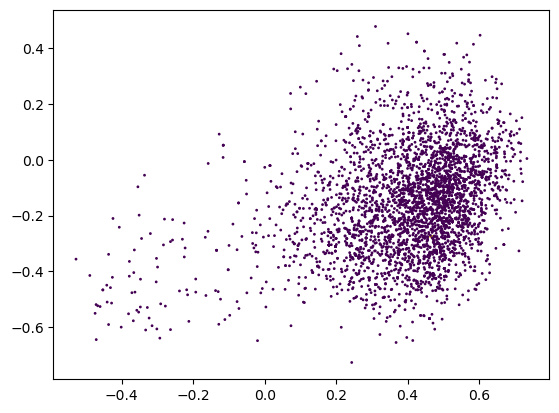

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

X=embeddings
# eps代表著圓的半徑，min_samples代表著以核心點為圓心的圓裡面所需包含的最小樣本數。
clustering=DBSCAN(eps=0.8,min_samples=30).fit(X)
clustering.labels_

plt.scatter(X[:,0],X[:,1],c=clustering.labels_ ,s=1)